In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
import time
import scipy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
matplotlib.rcParams['figure.figsize'] = (8,8)
from sklearn import preprocessing

sns.set_style('white')
pd.set_option('display.max_columns', 35)

In [2]:
print "Starting to read in data..."
t1 = time.time()
requests = pd.read_csv('311__Service_Requests.csv', parse_dates=True)
t2 = time.time()
print "Read in data in %.2f seconds." % (t2 - t1)


Starting to read in data...


//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Read in data in 6.86 seconds.


In [3]:
# processing on the data types
print "Starting to process data types..."
t1 = time.time()
for col in ['OPEN_DT', 'TARGET_DT', 'CLOSED_DT']:
    requests[col] = pd.to_datetime(requests[col], infer_datetime_format=True)
t2= time.time()
print "Dates processed in %.2f seconds." % (t2-t1)

Starting to process data types...
Dates processed in 559.38 seconds.


In [1]:
begin = pd.to_datetime('January 1, 2015 12:01AM')
end = pd.to_datetime('December 31, 2015 11:59PM')

closed_requests = requests[requests['CASE_STATUS'] == 'Closed']
closed_requests = closed_requests[(closed_requests['Source']=='Constituent Call') | (closed_requests['Source']=='Citizens Connect App')]

in_range= closed_requests[closed_requests['OPEN_DT'] > begin]
in_range = in_range[in_range['OPEN_DT'] < end]

times = (in_range['CLOSED_DT'] - in_range['OPEN_DT']).astype('timedelta64[m]')

times_scaled = preprocessing.scale(times)
latitude_scaled = preprocessing.scale(in_range['LATITUDE'])
longitude_scaled = preprocessing.scale(in_range['LONGITUDE'])

times_scaled_call = times_scaled[np.where(in_range['Source']=='Constituent Call')]
lat_scaled_call = latitude_scaled[np.where(in_range['Source']=='Constituent Call')]
long_scaled_call = longitude_scaled[np.where(in_range['Source']=='Constituent Call')]

times_scaled_app = times_scaled[np.where(in_range['Source']=='Citizens Connect App')]
lat_scaled_app = latitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]
long_scaled_app = longitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]

print len(times_scaled_app)
print len(times_scaled_call)

appdata = np.stack((times_scaled_app, lat_scaled_app, long_scaled_app), axis = 1)
calldata = np.stack((times_scaled_call, lat_scaled_call, long_scaled_call), axis = 1)

np.random.shuffle(appdata)
appdata = appdata[::4]
print appdata.shape
np.random.shuffle(calldata)
calldata = calldata[::10]
print calldata.shape


NameError: name 'pd' is not defined

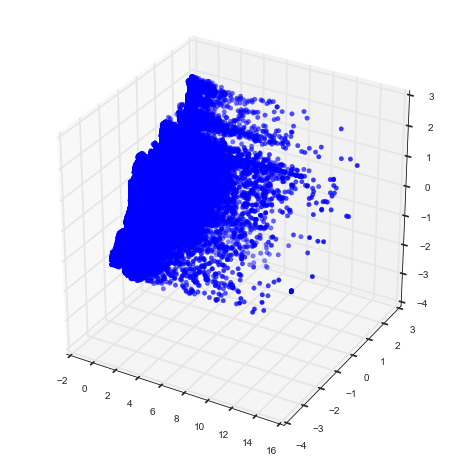

In [364]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(times_scaled, latitude_scaled, longitude_scaled, color = 'blue')
plt.show()

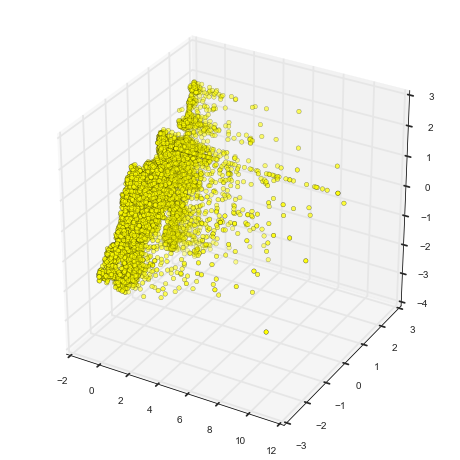

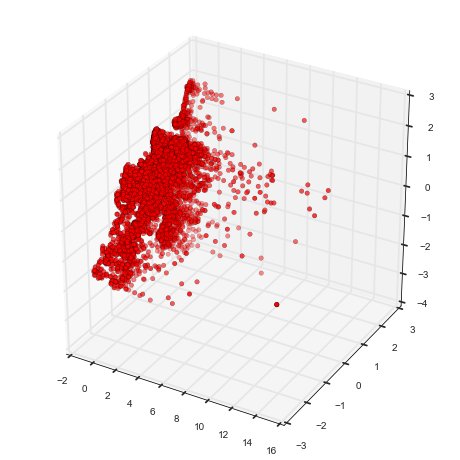

In [422]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(calldata[:,0], calldata[:,1], calldata[:,2], c = 'yellow')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(appdata[:,0], appdata[:,1], appdata[:,2], c = 'red')
plt.show()

In [427]:
from scipy.stats import invwishart, multivariate_normal, dirichlet

# It would be easier to debug if we implement each update separately
def update_Z(X, mu, Sigma, pi):
    """
    X: NxD matrix
    mu: Vector of k elements. Each element is a vector of D elements. 
    Sigma: Vector of k elements. Each element is a DxD covarianc ematrix
    pi: Vector of k scalars
    Returns Z, an NxK matrix made up of 1s and 0s (each row contains a single 1)
    """
    
    N = len(X)
    K = len(mu)
    Z = np.zeros((N,K))

    probs_vector = np.zeros(K)

    for i in range(N):
        for j in range(K):

            probs_vector[j] = pi[j]*multivariate_normal.pdf(X[i], mean = mu[j], cov = Sigma[j])
        normalization = np.sum(probs_vector)
        probs_vector = probs_vector/normalization
        Z[i] = np.random.multinomial(1, probs_vector)     
    
    return Z


def update_N_k(Z):
    """Returns a k-element vector describing number of elements in each cluster"""
    N_k = np.sum(Z, axis = 0)
    
    return N_k

def update_pi(alpha_k, Z):
    """
    alpha_k: Vector of K scalars
    Z: an NxK matrix
    pi: a vector of K scalars
    """
    N_k = np.sum(Z, axis = 0)
    pi = dirichlet.rvs(alpha_k+N_k)
    #specify that pi has to be in decreasing order
    while np.any(np.diff(pi)>0):
        pi = dirichlet.rvs(alpha_k+N_k)    
    return np.squeeze(pi)

def update_mean_x_k(Z, X, N_k):
    """
    Average value of observations belonging to cluster k
    mean_x_k: Matrix of dimension KxD
    """
    mean_x_k = np.zeros((len(N_k),len(X[0])))
    for i in range(len(mean_x_k)):
        for j in range(len(Z)):
            mean_x_k[i]+=Z[j][i]*X[j]
        mean_x_k[i] = mean_x_k[i]/N_k[i]

    
    return mean_x_k


def update_nu_k(nu_0, N_k):
    """
    returns a k-element vector
    """

    nu_k = nu_0+N_k

    return nu_k



def update_V_k(V_0, N_k, Sigma_k):
    """
    V_0: DxD matrix
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    """
    V_k = np.zeros_like(Sigma_k)
    V_0_inv = np.linalg.inv(V_0)
    for i in range(len(V_k)):
        inv = V_0_inv+N_k[i]*np.linalg.inv(Sigma_k[i])
        V_k[i] = np.linalg.inv(inv)             
        
    return V_k
    
def update_m_k(V_k, Sigma_k, N_k, mean_x_k, V_0, m_0):
    """
    V_0: DxD matrix
    m_0: Vector of K elements, each element has D elements
    N_k: Vector of k integers
    Sigma_k: Vector of k elements, each element is a DxD covariance matrix
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mean_x_k: DxK matrix describing average values of observations in each cluster
    """
    V_0_inv = np.linalg.inv(V_0)
    m_k = np.zeros((len(N_k), len(m_0)))
    for i in range(len(m_k)):
        Sig_inv = np.linalg.inv(Sigma_k[i])

        m_k[i] = np.dot(V_k[i],(np.dot(Sig_inv,N_k[i]*mean_x_k[i])+np.dot(V_0_inv,m_0)))
    return m_k

def update_mu_k(m_k, V_k):
    """
    m_k: Vector of k elements, each element has a vector with D elements
    V_k: Vector of k elements, each element is a DxD covariance matrix
    mu_k: Vector of k elements, each element has a vector with D elements
    """
    mu_k = np.zeros_like(m_k)

    for i in range(len(mu_k)):
        mu_k[i] = multivariate_normal.rvs(mean = m_k[i], cov = V_k[i])

    return mu_k

def update_S_k(Z, X, mu_k, S_0):
    """
    S_0: DxD matrix
    Scale matrices for inverse wishart distribution
    Returns array of k matrices (DxD)
    """
    S_k = np.zeros((len(mu_k), S_0.shape[0], S_0.shape[1]))
    for j in range(len(mu_k)):
        S_k[j]=np.copy(S_0)
        for i in range(len(Z)):
            S_k[j]+=Z[i][j]*np.outer((X[i]-mu_k[j]),(X[i]-mu_k[j]))
    return S_k

def update_Sigma_k(S_k, nu_k):
    """
    Covariance matrices for the k clusters
    Returns array of k matrices of dimension DxD
    """
    Sigma_k = np.zeros_like(S_k)
    for i in range(len(nu_k)):
        Sigma_k[i] = invwishart.rvs(nu_k[i], S_k[i])
    return Sigma_k

# this function can be reused even when we change the prior on pi 
def gibbs_gmm(K, X, pi, mu, Sigma, nu_0, S_0, V_0, m_0, alpha_0):
    """
    K: number of components
    X: observations
    nu_0: dof for inverse Wishart distribution
    S_0: scale matrix for inverse Wishart distribution
    m_0: Mean of normal-inverse-Wishart distribution
    V_0: Covariance matrix of normal-inverse-Wishart distribution
    alpha_0: parameter for Dirichlet distribution
    """
    numsamples = 300
    start = time.time()
    Z_samples = np.zeros((numsamples, X.shape[0], pi.shape[0]))
    mu_samples = np.zeros((numsamples, mu.shape[0], mu.shape[1]))
    pi_samples = np.zeros((numsamples, K))
    Sigma_samples = np.zeros((numsamples, K, Sigma.shape[1], Sigma.shape[2]))
    nu_samples = np.zeros((numsamples, K))
    V_samples = np.zeros((numsamples, K, V_0.shape[0],V_0.shape[1]))
    m_samples = np.zeros((numsamples, K, m_0.shape[0]))
    S_samples = np.zeros_like(Sigma_samples)

    Z_samples[0] = update_Z(X, mu, Sigma, pi)
    N_k = update_N_k(Z_samples[0])
    pi_samples[0] = pi
    mean_x_k = update_mean_x_k(Z_samples[0], X, N_k)
    mu_samples[0] = mu
    Sigma_samples[0] = Sigma
    nu_samples[0] = update_nu_k(nu_0, N_k)
    V_samples[0] = update_V_k(V_0, N_k, Sigma_samples[0])
    m_samples[0] = update_m_k(V_samples[0], Sigma_samples[0], N_k, mean_x_k, V_0, m_0)
    S_samples[0] = update_S_k(Z_samples[0], X, mu_samples[0], S_0)

    for i in range(1,numsamples):
    
        Z_samples[i]= update_Z(X, mu_samples[i-1], Sigma_samples[i-1], pi_samples[i-1])
        N_k = update_N_k(Z_samples[i])
        if i%25==0:
            print i, time.time()-start
        pi_samples[i] = update_pi(alpha_0, Z_samples[i])
        mean_x_k = update_mean_x_k(Z_samples[i], X, N_k)
        mu_samples[i] = update_mu_k(m_samples[i-1], V_samples[i-1])
        Sigma_samples[i] = update_Sigma_k(S_samples[i-1], nu_samples[i-1])
        nu_samples[i] = update_nu_k(nu_0, N_k)
        V_samples[i]= update_V_k(V_0, N_k, Sigma_samples[i])
        m_samples[i] = update_m_k(V_samples[i], Sigma_samples[i], N_k, mean_x_k, V_0, m_0)
        S_samples[i] = update_S_k(Z_samples[i], X, mu_samples[i], S_0)

    return Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples



In [367]:
#app data fitting
K = 2
pi = np.array([0.9, 0.1])

Sigma = np.array([np.eye(3), np.eye(3)])

mu = np.array([[-0.2, 0,0],[3, 0,0]]) 
Z  = update_Z(appdata, mu, Sigma, pi)

nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1.])



Z_samples, pi_samples, mu_samples, Sigma_samples, nu_samples, V_samples, m_samples, S_samples= gibbs_gmm(K, 
                                                                                                         appdata, 
                                                                                                         pi, 
                                                                                                         Z, 
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)



[[-0.15708606  0.31178046  0.10131314]
 [ 3.62115418  0.3417475   0.09439736]]
25 100.48226285
50 207.144897938
75 306.824374914
100 433.615657806
125 551.776534796
150 666.862881899
175 766.101648808
200 861.824795961
225 957.015619993
250 1054.67819095
275 1150.48200679


In [368]:
burnin = 75

def get_mu_posterior(mu_samples, K, burnin):
    mu_avg = np.zeros_like(mu_samples[0])
    mu_std = np.zeros_like(mu_samples[0])
    for i in range(K):
        mu_avg[i] = np.mean(mu_samples[burnin:,i], axis = 0)
        mu_std[i] = np.std(mu_samples[burnin:,i], axis = 0)
    return mu_avg, mu_std

def get_pi_posterior(pi_samples, burnin):
    return np.mean(pi_samples[burnin:],axis = 0), np.std(pi_samples[burnin:], axis = 0)

def get_Sigma_posterior(Sigma_samples, burnin):
    return np.mean(Sigma_samples[burnin:],axis = 0), np.std(Sigma_samples[burnin:], axis = 0)

mu_avg, mu_std = get_mu_posterior(mu_samples, K, burnin)
pi_avg, pi_std = get_pi_posterior(pi_samples, burnin)
Sigma_avg, Sigma_std = get_Sigma_posterior(Sigma_samples, burnin)

print mu_avg
print mu_std
print 
print pi_avg
print pi_std
print
print Sigma_avg
print Sigma_std

[[-0.42486061  0.31869346  0.14095189]
 [ 0.61581172  0.30388932  0.04055524]]
[[ 0.00048072  0.00748471  0.00811888]
 [ 0.01615141  0.01071268  0.01153441]]

[ 0.59559616  0.40440384]
[ 0.00382166  0.00382166]

[[[  1.51696782e-03  -3.34127388e-03  -2.50495577e-03]
  [ -3.34127388e-03   6.50908731e-01   2.96683292e-01]
  [ -2.50495577e-03   2.96683292e-01   8.80737949e-01]]

 [[  1.97443192e+00   1.00032311e-02   1.42842230e-02]
  [  1.00032311e-02   7.26557550e-01   2.99003293e-01]
  [  1.42842230e-02   2.99003293e-01   9.47053701e-01]]]
[[[  3.70432752e-05   3.67526197e-04   3.71709506e-04]
  [  3.67526197e-04   9.24499550e-03   7.75989404e-03]
  [  3.71709506e-04   7.75989404e-03   1.17213468e-02]]

 [[  3.30213782e-02   1.45454536e-02   1.56820235e-02]
  [  1.45454536e-02   1.27159346e-02   1.08902126e-02]
  [  1.56820235e-02   1.08902126e-02   1.74260368e-02]]]


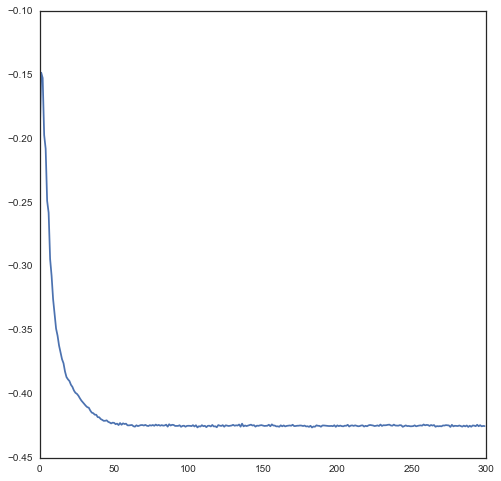

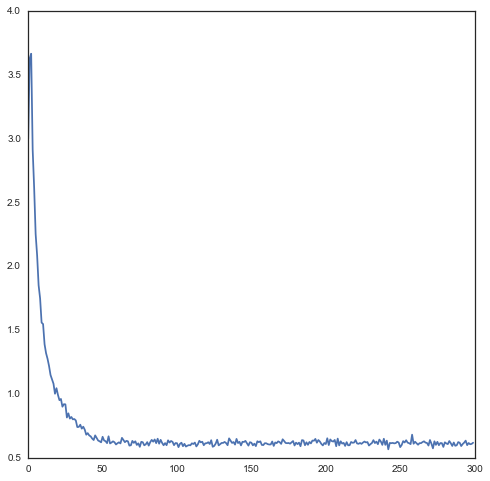

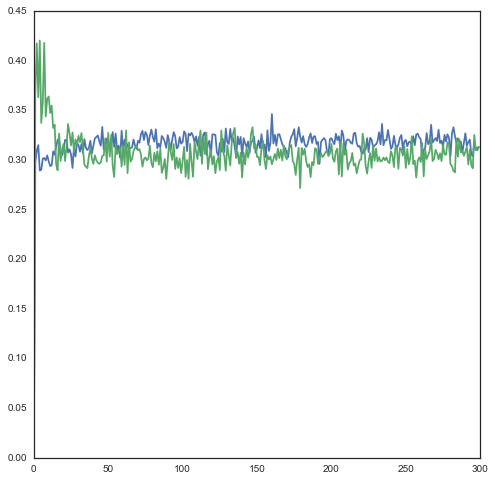

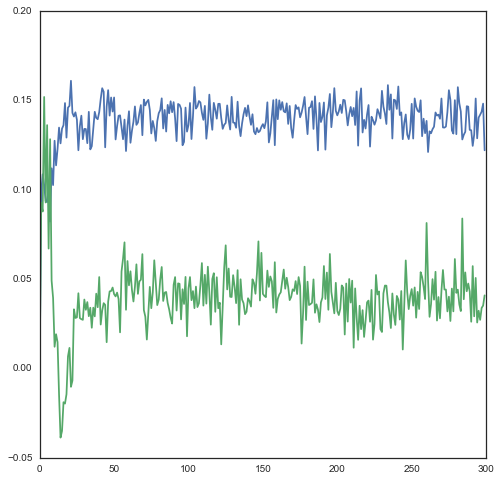

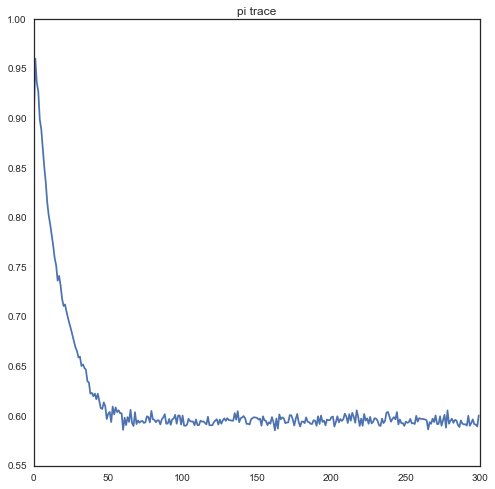

In [369]:

plt.plot(mu_samples[:,0, 0])
plt.show()
plt.plot(mu_samples[:,1, 0])
plt.show()

plt.plot(mu_samples[:,0, 1])
plt.plot(mu_samples[:,1, 1])
plt.show()

plt.plot(mu_samples[:,0, 2])
plt.plot(mu_samples[:,1, 2])
plt.show()


plt.plot(pi_samples[:,0])
plt.title('pi trace')
plt.show()

#print mu_samples[burnin:,0].shape

In [370]:
labelmode, count = scipy.stats.mstats.mode(Z_samples[burnin:])
labelmode = np.squeeze(labelmode)

In [371]:
print labelmode.shape
cluster1 = appdata[np.where(labelmode[:,0]==1)]
cluster2 = appdata[np.where(labelmode[:,1]==1)]
print burnin

(18482, 2)
75


In [372]:
print cluster1.shape
print cluster2.shape

leftovers = appdata[np.where((labelmode[:,0]==0)&(labelmode[:,1]==0))]
print np.where((labelmode[:,0]==0)&(labelmode[:,1]==0))

(11321, 3)
(7161, 3)
(array([], dtype=int64),)


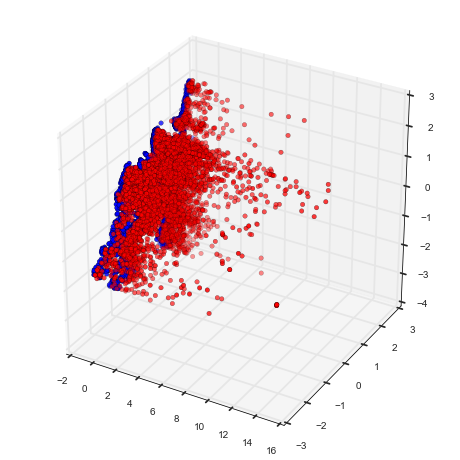

In [373]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(cluster1[:,0], cluster1[:,1], cluster1[:,2], c = 'blue')
ax.scatter(cluster2[:,0], cluster2[:,1], cluster2[:,2], c = 'red')
plt.show()

In [374]:
print np.mean(cluster1, axis = 0)
print np.mean(cluster2, axis = 0)
print np.std(cluster1, axis = 0)
print np.std(cluster2, axis = 0)

[-0.42409533  0.316845    0.13707514]
[ 0.65989476  0.30671597  0.04380178]
[ 0.03809488  0.80816556  0.94001806]
[ 1.41879741  0.85169926  0.97254716]


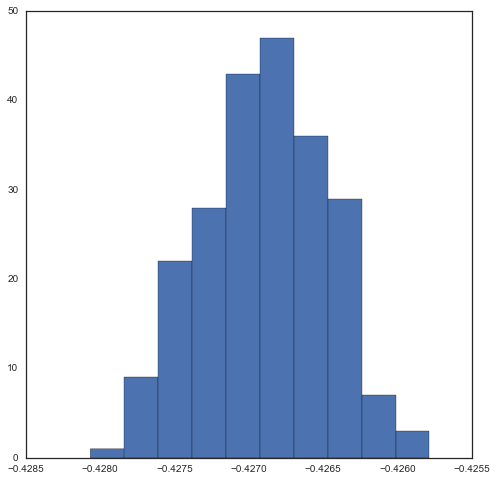

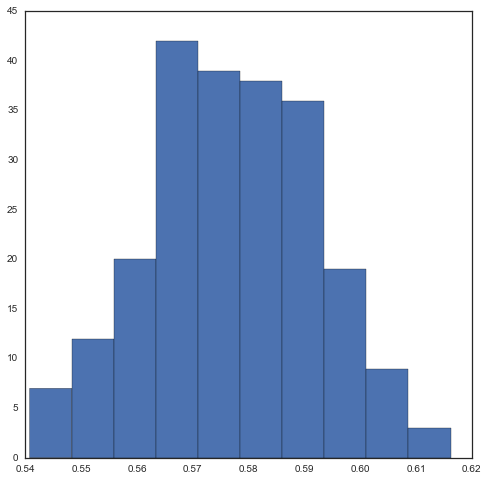

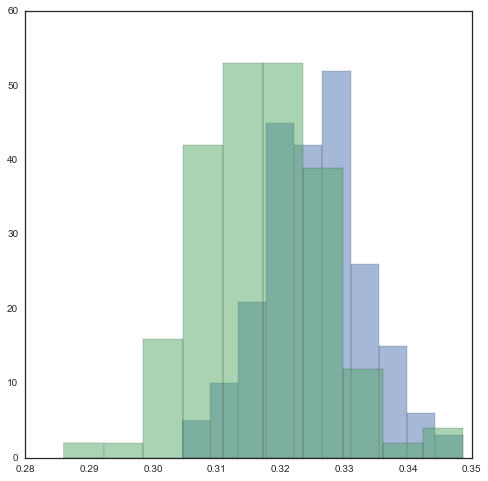

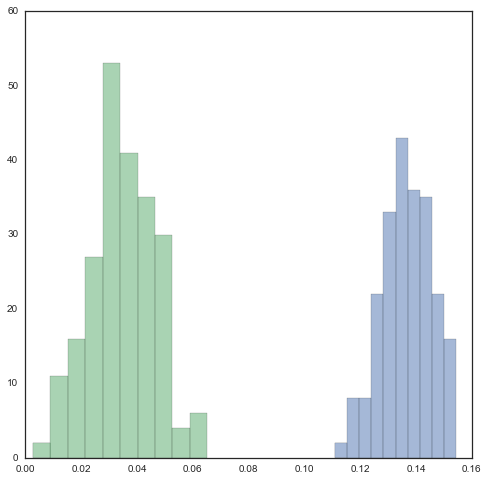

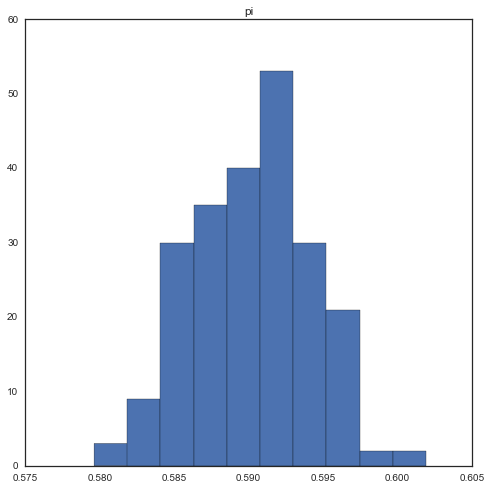

In [202]:
plt.hist(mu_samples[burnin:,0, 0])
plt.show()
plt.hist(mu_samples[burnin:,1, 0])
plt.show()

plt.hist(mu_samples[burnin:,0, 1], alpha = 0.5)
plt.hist(mu_samples[burnin:,1, 1], alpha = 0.5)
plt.show()

plt.hist(mu_samples[burnin:,0, 2],alpha = 0.5)
plt.hist(mu_samples[burnin:,1, 2],alpha = 0.5)
plt.show()


plt.hist(pi_samples[burnin:,0])
plt.title('pi')
plt.show()

In [376]:
#call data fitting
K = 2
pi = np.array([0.5, 0.5])

Sigma = np.array([np.eye(3), np.eye(3)])

mu = np.array([[0, 0,0],[0, 0,0]]) 
Z_c  = update_Z(calldata, mu, Sigma, pi)

nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1.])



Z_samples_c, pi_samples_c, mu_samples_c, Sigma_samples_c, nu_samples_c, V_samples_c, m_samples_c, S_samples_c= gibbs_gmm(K, 
                                                                                                         calldata, 
                                                                                                         pi, 
                                                                                                         Z_c, 
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

[[ 0.00781285 -0.11385208 -0.04907138]
 [ 0.00912508 -0.12201297 -0.03798151]]
25 104.936233997
50 210.03877902
75 315.284446001
100 420.731038094
125 541.834764004
150 647.574884176
175 752.972273111
200 858.253406048
225 965.97420907
250 1071.23015213
275 1176.35557103


In [377]:

mu_avg_c, mu_std_c = get_mu_posterior(mu_samples_c, K, burnin)
pi_avg_c, pi_std_c = get_pi_posterior(pi_samples_c, burnin)
Sigma_avg_c, Sigma_std_c = get_Sigma_posterior(Sigma_samples_c, burnin)

print mu_avg_c
print mu_std_c
print 
print pi_avg_c
print pi_std_c
print
print Sigma_avg_c
print Sigma_std_c

[[-0.3655694  -0.14960846 -0.08967718]
 [ 0.96156738 -0.03851036  0.07267444]]
[[ 0.00103262  0.0084706   0.00850167]
 [ 0.02178384  0.01346574  0.01284472]]

[ 0.7182657  0.2817343]
[ 0.00351723  0.00351723]

[[[  9.92789626e-03  -9.26373562e-03  -1.85412409e-03]
  [ -9.26373562e-03   1.13433540e+00   5.60335344e-01]
  [ -1.85412409e-03   5.60335344e-01   1.09689701e+00]]

 [[  2.42921151e+00   4.12202015e-02  -5.77747848e-02]
  [  4.12202015e-02   9.13280917e-01   3.46012930e-01]
  [ -5.77747848e-02   3.46012930e-01   8.58180767e-01]]]
[[[ 0.00016468  0.00099082  0.00095062]
  [ 0.00099082  0.01349935  0.00986637]
  [ 0.00095062  0.00986637  0.01299122]]

 [[ 0.04702126  0.01970585  0.01938025]
  [ 0.01970585  0.0189091   0.01347807]
  [ 0.01938025  0.01347807  0.01530613]]]


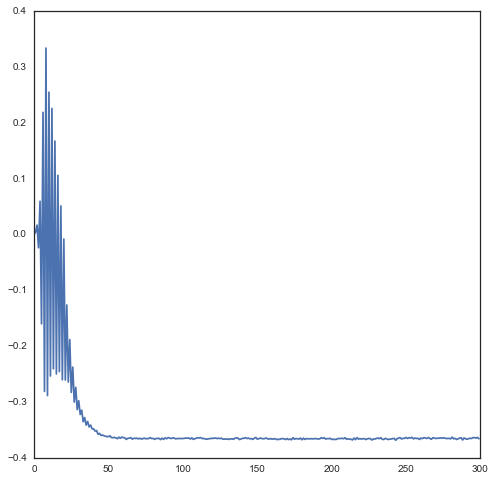

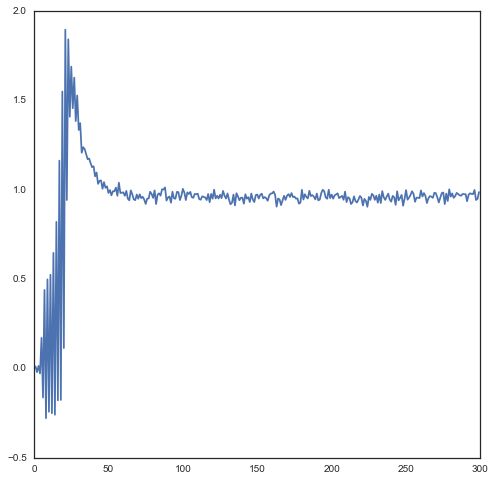

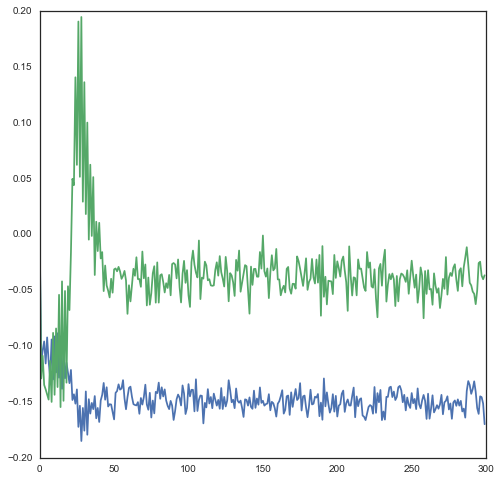

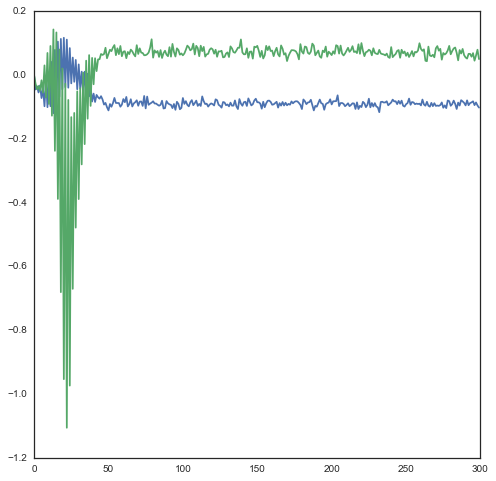

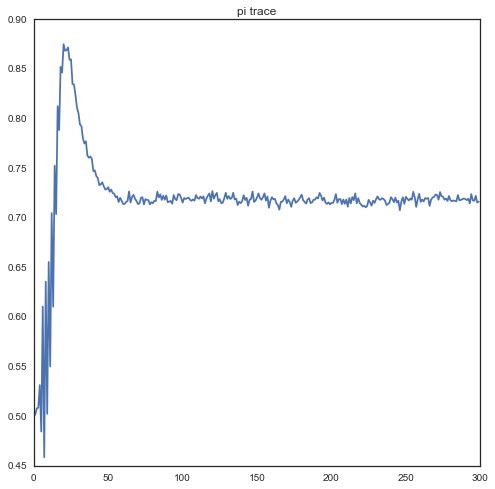

In [378]:
plt.plot(mu_samples_c[:,0, 0])
plt.show()
plt.plot(mu_samples_c[:,1, 0])
plt.show()

plt.plot(mu_samples_c[:,0, 1])
plt.plot(mu_samples_c[:,1, 1])
plt.show()

plt.plot(mu_samples_c[:,0, 2])
plt.plot(mu_samples_c[:,1, 2])
plt.show()


plt.plot(pi_samples_c[:,0])
plt.title('pi trace')
plt.show()

In [379]:
labelmode_c, count = scipy.stats.mstats.mode(Z_samples_c[burnin:])
labelmode_c = np.squeeze(labelmode_c)
cluster1_c = calldata[np.where(labelmode_c[:,0]==1)]
cluster2_c = calldata[np.where(labelmode_c[:,1]==1)]

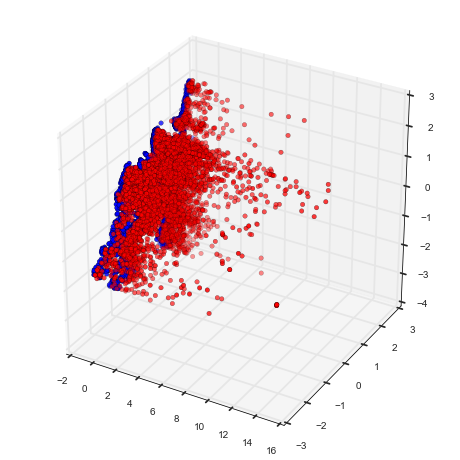

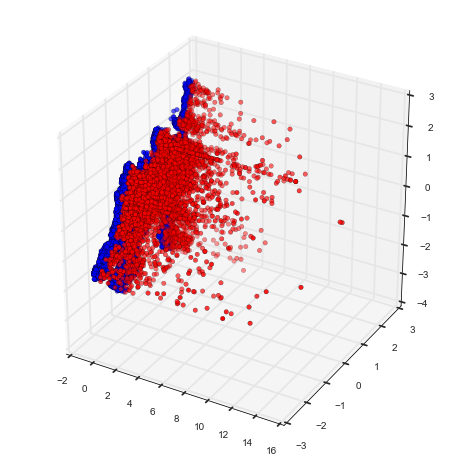

[-0.36432807 -0.14668231 -0.08149223]
[ 1.07549321 -0.03602688  0.06476751]


In [381]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(cluster1[:,0], cluster1[:,1], cluster1[:,2], c = 'blue')
ax.scatter(cluster2[:,0], cluster2[:,1], cluster2[:,2], c = 'red')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(cluster1_c[:,0], cluster1_c[:,1], cluster1_c[:,2], c = 'blue')
ax.scatter(cluster2_c[:,0], cluster2_c[:,1], cluster2_c[:,2], c = 'red')
plt.show()

print np.mean(cluster1_c, axis = 0)
print np.mean(cluster2_c, axis = 0)

In [221]:
def posterior_predictive(pi_posterior, mu_posterior, Sigma_posterior):
    K = 2
    samplesize = 10000
    labels = np.zeros((samplesize, K))
    predicted_vals = np.zeros((samplesize, 3))
    #draw from posteriors
    draw = np.random.randint(low = 0, high = len(pi_posterior)+1)
    pi_draw = pi_posterior[draw]
    mu_draw = mu_posterior[draw]
    Sigma_draw = Sigma_posterior[draw]
    #now sample from likelihood
    #first, determine which cluster the randomly drawn point belongs to 
    for i in range(samplesize):
        r = np.random.uniform()
        if r < pi_draw[0]:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[0], cov = Sigma_draw[0])
            labels[i] = np.array([1,0])
        else:
            predicted_vals[i] = multivariate_normal.rvs(mean = mu_draw[1], cov = Sigma_draw[1])
            labels[i] = np.array([0,1])
    return predicted_vals, labels

            
        
        
        
    

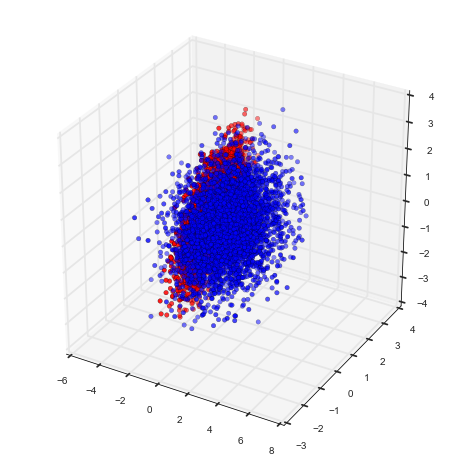

In [382]:

predictedvals, predictedlabels = posterior_predictive(pi_samples[burnin:], 
                                                      mu_samples[burnin:], 
                                                      Sigma_samples[burnin:])


cluster1_app_predict = predictedvals[np.where(predictedlabels[:,0]==1)]
cluster2_app_predict = predictedvals[np.where(predictedlabels[:,1]==1)]

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(cluster1_app_predict[:,0], cluster1_app_predict[:,1], cluster1_app_predict[:,2], c = 'red')
ax.scatter(cluster2_app_predict[:,0], cluster2_app_predict[:,1], cluster2_app_predict[:,2], c = 'blue')
plt.show()


In [428]:
#call data fitting
K = 3

#initializing with MAP results
pi = np.array([ 0.85561417, 0.13795177, 0.00643406])

Sigma = np.array([[[ 0.109255, 0.00936383, -0.00547017], 
                   [0.00936383, 1.12566872, 0.55098458], 
                   [-0.00547017, 0.55098458, 1.22771629]], 
                 [[ 1.92483963, 0.06452807, 0.0097768 ], 
                  [ 0.06452807,  1.28456653,  0.29894916],
                  [ 0.0097768,   0.29894916,  1.28388214]],
                 [[ 10.56069314, 0.4418922, 0.16616875], 
                  [0.4418922, 8.54962789,0.88448615],
                  [0.16616875, 0.88448615, 8.52842064]]])

mu = np.array([[ -2.85596910e-01,  -8.06180353e-02,  -2.30132447e-01], 
               [  1.44914839e+00,   5.81729345e-03,  -1.00870066e-01],
               [  7.00437911e+00,  -1.35817042e-01,  -1.67447475e-01]])
#Z_c3  = update_Z(calldata, mu, Sigma, pi)

nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1., 1.])



Z_samples_c3, pi_samples_c3, mu_samples_c3, Sigma_samples_c3, nu_samples_c3, V_samples_c3, m_samples_c3, S_samples_c3= gibbs_gmm(K, 
                                                                                                         calldata, 
                                                                                                         pi,  
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

25 82.5710070133
50 394.473448992
75 475.132950068
100 559.526870966
125 637.090076923
150 723.036016941
175 803.345087051
200 880.641761065
225 957.889580965
250 1035.17986488
275 1114.05053401


In [430]:
burnin  = 150
mu_avg_c3, mu_std_c3 = get_mu_posterior(mu_samples_c3, K, burnin)
pi_avg_c3, pi_std_c3 = get_pi_posterior(pi_samples_c3, burnin)
Sigma_avg_c3, Sigma_std_c3 = get_Sigma_posterior(Sigma_samples_c3, burnin)

print mu_avg_c3
print mu_std_c3
print 
print pi_avg_c3
print pi_std_c3
print
print Sigma_avg_c3
print Sigma_std_c3

[[-0.42003113 -0.11211709 -0.14781161]
 [-0.15202993 -0.21778752  0.14739259]
 [ 1.39263365  0.06657807 -0.0913319 ]]
[[ 0.00083224  0.01775083  0.01737368]
 [ 0.00561825  0.02433158  0.02259669]
 [ 0.03777542  0.0259792   0.02987696]]

[ 0.48407109  0.32511116  0.19081775]
[ 0.00658261  0.00693822  0.00475924]

[[[  1.64558704e-03  -5.05960212e-03  -6.06685512e-03]
  [ -5.05960212e-03   1.10570657e+00   5.48170593e-01]
  [ -6.06685512e-03   5.48170593e-01   1.14361761e+00]]

 [[  4.17044063e-02   6.34553121e-03   4.75390314e-03]
  [  6.34553121e-03   1.11823939e+00   5.92313818e-01]
  [  4.75390314e-03   5.92313818e-01   7.50927073e-01]]

 [[  2.77574849e+00  -3.02968786e-02   2.84560426e-01]
  [ -3.02968786e-02   8.89778522e-01   3.01842712e-01]
  [  2.84560426e-01   3.01842712e-01   1.17757257e+00]]]
[[[  6.63507425e-05   6.32082934e-04   6.60522662e-04]
  [  6.32082934e-04   2.20102859e-02   1.84375467e-02]
  [  6.60522662e-04   1.84375467e-02   2.24040254e-02]]

 [[  1.63944353e-0

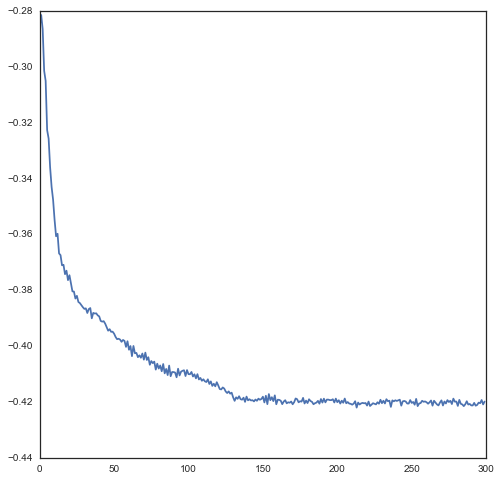

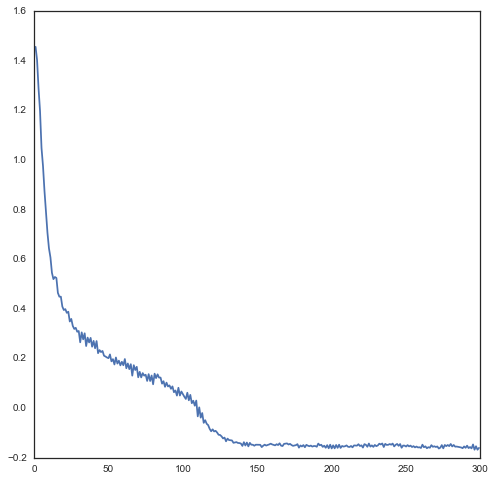

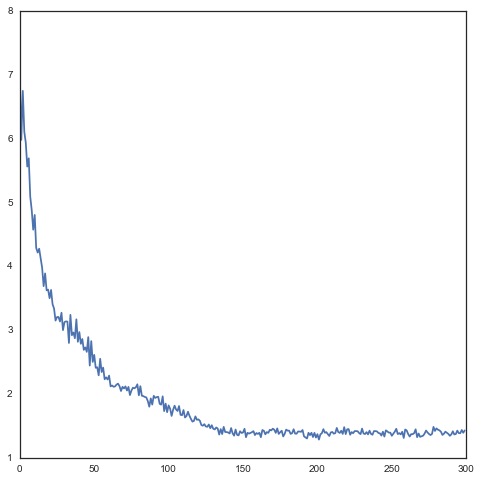

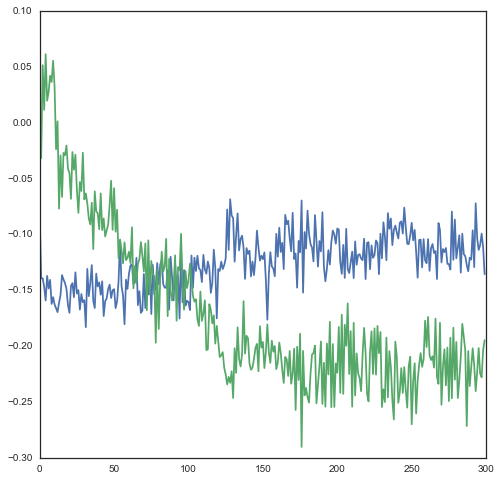

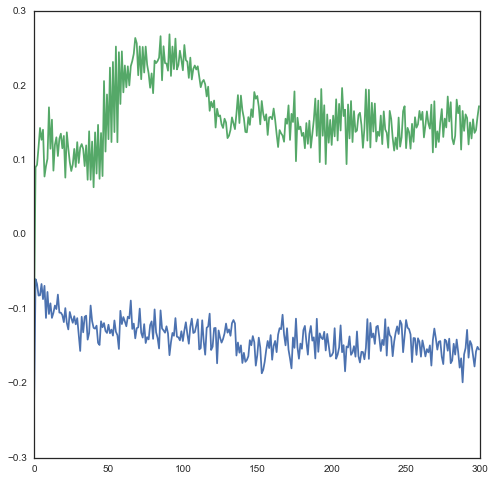

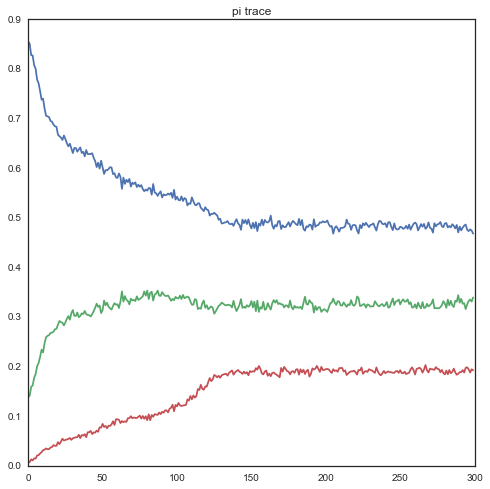

In [429]:
plt.plot(mu_samples_c3[:,0, 0])
plt.show()
plt.plot(mu_samples_c3[:,1, 0])
plt.show()
plt.plot(mu_samples_c3[:,2, 0])
plt.show()

plt.plot(mu_samples_c3[:,0, 1])
plt.plot(mu_samples_c3[:,1, 1])
plt.show()

plt.plot(mu_samples_c3[:,0, 2])
plt.plot(mu_samples_c3[:,1, 2])
plt.show()


plt.plot(pi_samples_c3[:,0])
plt.plot(pi_samples_c3[:,1])
plt.plot(pi_samples_c3[:,2])
plt.title('pi trace')
plt.show()

In [298]:

in_range_new = in_range[in_range['TARGET_DT'] > begin] #make sure target dt has valid values
in_range_new = in_range_new[(in_range_new['TARGET_DT']-in_range_new['OPEN_DT'] ).astype('timedelta64[m]')>0]

delays = (in_range_new['CLOSED_DT']-in_range_new['TARGET_DT'] ).astype('timedelta64[m]')
expected_responses = (in_range_new['TARGET_DT']-in_range_new['OPEN_DT'] ).astype('timedelta64[m]')
actual = (in_range_new['CLOSED_DT']-in_range_new['OPEN_DT'] ).astype('timedelta64[m]')
delays_scaled = preprocessing.scale(delays)
delayfrac = actual/expected_responses
latitude_scaled_new = preprocessing.scale(in_range_new['LATITUDE'])
longitude_scaled_new = preprocessing.scale(in_range_new['LONGITUDE'])

delays_new_call = delays_scaled[np.where(in_range_new['Source']=='Constituent Call')]
lat_new_call = latitude_scaled_new[np.where(in_range_new['Source']=='Constituent Call')]
long_new_call = longitude_scaled_new[np.where(in_range_new['Source']=='Constituent Call')]

delays_new_app = delays_scaled[np.where(in_range_new['Source']=='Citizens Connect App')]
lat_new_app = latitude_scaled_new[np.where(in_range_new['Source']=='Citizens Connect App')]
long_new_app = longitude_scaled_new[np.where(in_range_new['Source']=='Citizens Connect App')]

appdata_new = np.stack((delays_new_app, lat_new_app, long_new_app), axis = 1)
calldata_new = np.stack((delays_new_call, lat_new_call, long_new_call), axis = 1)

np.random.shuffle(appdata_new)
appdata_new = appdata_new[::2]
print appdata_new.shape
np.random.shuffle(calldata_new)
calldata_new = calldata_new[::5]
print calldata_new.shape
"""
times_scaled = preprocessing.scale(times)
latitude_scaled = preprocessing.scale(in_range['LATITUDE'])
longitude_scaled = preprocessing.scale(in_range['LONGITUDE'])

times_scaled_call = times_scaled[np.where(in_range['Source']=='Constituent Call')]
lat_scaled_call = latitude_scaled[np.where(in_range['Source']=='Constituent Call')]
long_scaled_call = longitude_scaled[np.where(in_range['Source']=='Constituent Call')]

times_scaled_app = times_scaled[np.where(in_range['Source']=='Citizens Connect App')]
lat_scaled_app = latitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]
long_scaled_app = longitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]

print len(times_scaled_app)
print len(times_scaled_call)

appdata = np.stack((times_scaled_app, lat_scaled_app, long_scaled_app), axis = 1)
calldata = np.stack((times_scaled_call, lat_scaled_call, long_scaled_call), axis = 1)

np.random.shuffle(appdata)
appdata = appdata[::2]
print appdata.shape
np.random.shuffle(calldata)
calldata = calldata[::5]
print calldata.shape

"""


(18157, 3)
(15868, 3)


"\ntimes_scaled = preprocessing.scale(times)\nlatitude_scaled = preprocessing.scale(in_range['LATITUDE'])\nlongitude_scaled = preprocessing.scale(in_range['LONGITUDE'])\n\ntimes_scaled_call = times_scaled[np.where(in_range['Source']=='Constituent Call')]\nlat_scaled_call = latitude_scaled[np.where(in_range['Source']=='Constituent Call')]\nlong_scaled_call = longitude_scaled[np.where(in_range['Source']=='Constituent Call')]\n\ntimes_scaled_app = times_scaled[np.where(in_range['Source']=='Citizens Connect App')]\nlat_scaled_app = latitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]\nlong_scaled_app = longitude_scaled[np.where(in_range['Source']=='Citizens Connect App')]\n\nprint len(times_scaled_app)\nprint len(times_scaled_call)\n\nappdata = np.stack((times_scaled_app, lat_scaled_app, long_scaled_app), axis = 1)\ncalldata = np.stack((times_scaled_call, lat_scaled_call, long_scaled_call), axis = 1)\n\nnp.random.shuffle(appdata)\nappdata = appdata[::2]\nprint appdata.shap

-18434.8255772
129385.647071
-1050066.0
634838.0


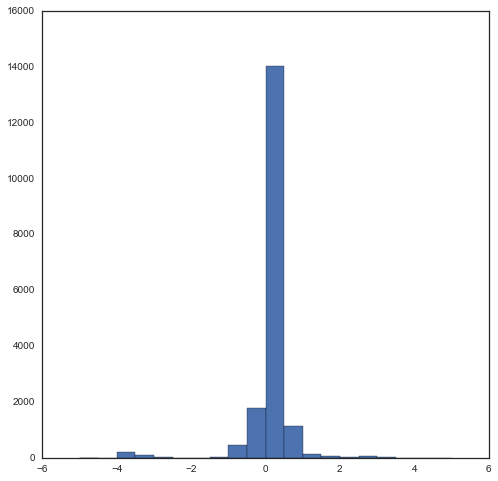

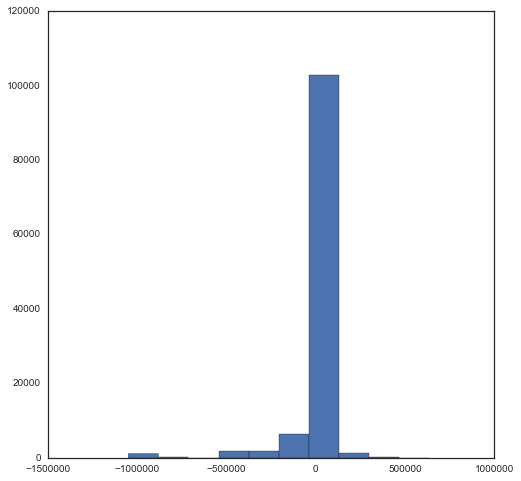

41755
73879
13551
2317
-7.97330459578
5.04903627538
-7.97284074661


In [349]:
print np.mean(delays)
print np.std(delays)
print np.min(delays)
print np.max(delays)
plt.hist(appdata_new[:,0], range = (-5, 5), bins  = 20)
plt.show()

plt.hist(delays)
plt.show()
print len(np.where(delays>0)[0])
print len(np.where(delays<0)[0])

print len(np.where(calldata_new[:,0]>0)[0])
print len(np.where(calldata_new[:,0]<0)[0])

print np.min(delays_scaled)
print np.max(delays_scaled)

print (-1050000+18434)/129385.



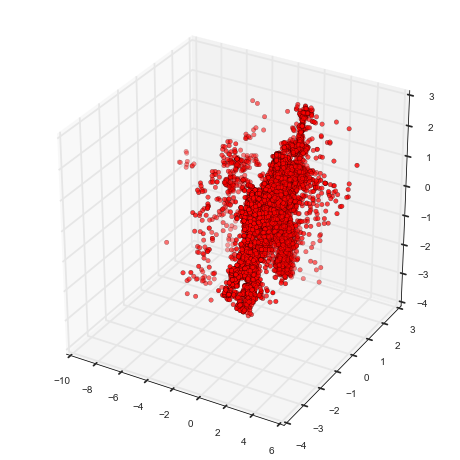

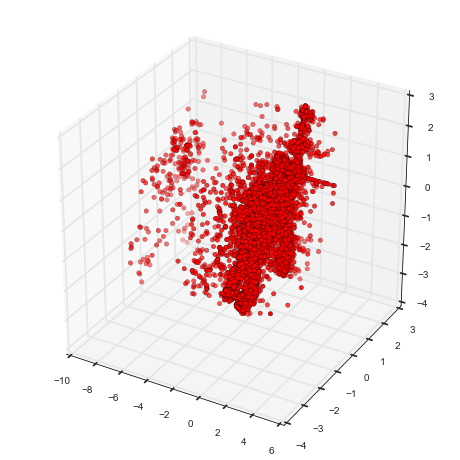

In [278]:
#keep in mind with these clusters that the mean delay time is negative (i.e., most finish on time)

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(appdata_new[:,0], appdata_new[:,1], appdata_new[:,2], c = 'red')
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(calldata_new[:,0], calldata_new[:,1], calldata_new[:,2], c = 'red')
plt.show()

In [334]:
#call data fitting of delays
K = 2
pi = np.array([0.5, 0.5])

Sigma = np.array([np.eye(3), np.eye(3)])

mu = np.array([[0, 0,0],[0, 0,0]]) 
Z_cd  = update_Z(calldata_new, mu, Sigma, pi)

nu_0 = 3
S_0 = np.eye(3)
V_0 =  np.eye(3)
m_0 = np.array([1., 1., 1.])  
alpha_0 = np.array([1., 1.])



Z_samples_cd, pi_samples_cd, mu_samples_cd, Sigma_samples_cd, nu_samples_cd, V_samples_cd, m_samples_cd, S_samples_cd= gibbs_gmm(K, 
                                                                                                         calldata_new, 
                                                                                                         pi, 
                                                                                                         Z_cd, 
                                                                                                         mu, 
                                                                                                         Sigma, 
                                                                                                         nu_0, 
                                                                                                         S_0, 
                                                                                                         V_0, 
                                                                                                         m_0, 
                                                                                                         alpha_0)

[[-0.04319273 -0.1172634  -0.03791115]
 [-0.03689498 -0.12184559 -0.03991545]]
25 84.3132350445
50 168.434757948
75 250.161725998
100 335.487358093
125 417.706095934
150 499.697816133
175 581.540903091


In [335]:
mu_avg_cd, mu_std_cd = get_mu_posterior(mu_samples_cd, K, burnin)
pi_avg_cd, pi_std_cd = get_pi_posterior(pi_samples_cd, burnin)
Sigma_avg_cd, Sigma_std_cd = get_Sigma_posterior(Sigma_samples_cd, burnin)

print mu_avg_cd
print mu_std_cd
print 
print pi_avg_cd
print pi_std_cd
print
print Sigma_avg_cd
print Sigma_std_cd

[[ 0.13817527 -0.17216146 -0.07314942]
 [-0.54855185  0.03530391  0.06199502]]
[[ 0.00062391  0.01108878  0.00935534]
 [ 0.03203674  0.01615406  0.01731132]]

[ 0.74317117  0.25682883]
[ 0.00343237  0.00343237]

[[[  4.16749943e-03  -4.55296317e-03   1.81317467e-03]
  [ -4.55296317e-03   1.14203769e+00   5.48059485e-01]
  [  1.81317467e-03   5.48059485e-01   1.07803396e+00]]

 [[  4.63768974e+00  -4.33508090e-03   9.08995330e-02]
  [ -4.33508090e-03   9.10957940e-01   3.76171044e-01]
  [  9.08995330e-02   3.76171044e-01   8.81085947e-01]]]
[[[  8.10083360e-05   6.61274922e-04   6.46108482e-04]
  [  6.61274922e-04   1.44575165e-02   1.20293136e-02]
  [  6.46108482e-04   1.20293136e-02   1.41918661e-02]]

 [[  9.60829410e-02   3.42825809e-02   3.16898902e-02]
  [  3.42825809e-02   2.02955047e-02   1.68790653e-02]
  [  3.16898902e-02   1.68790653e-02   1.97397620e-02]]]


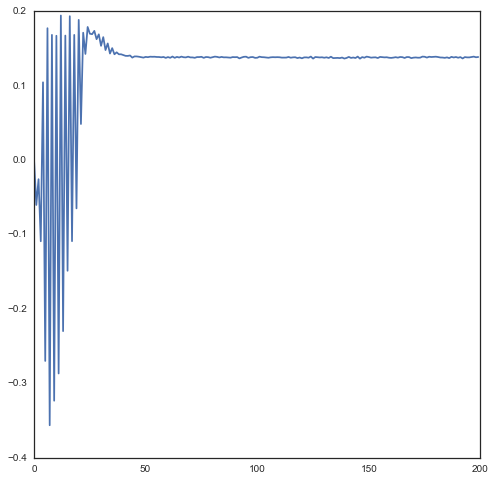

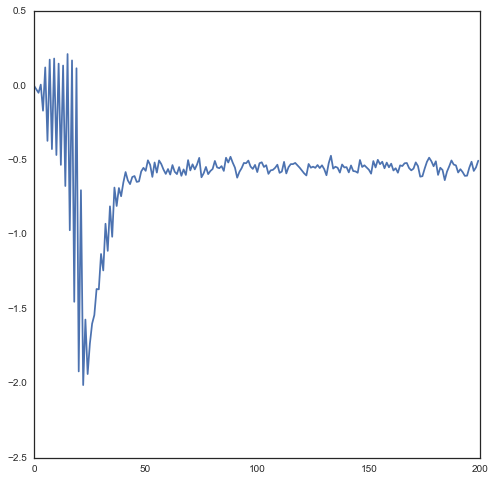

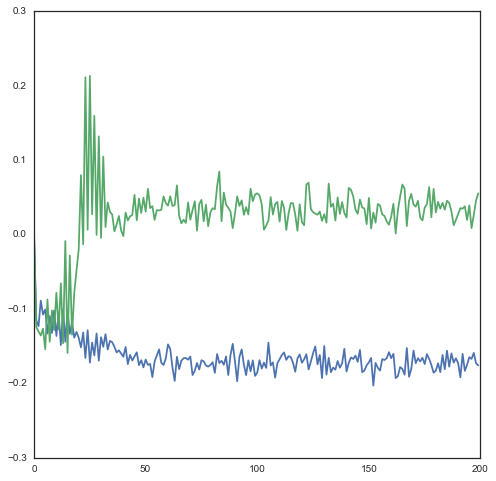

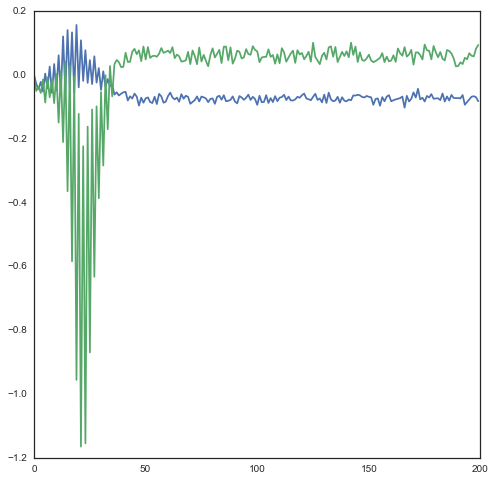

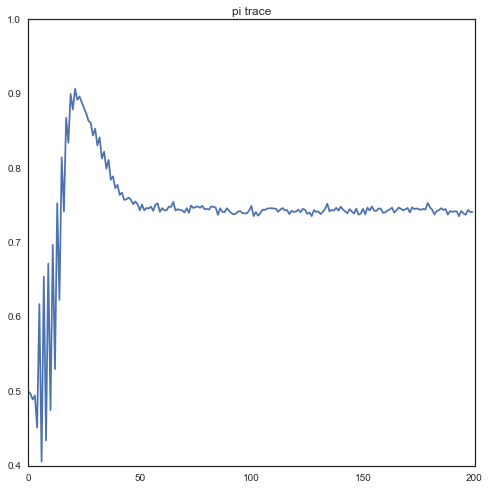

In [336]:
plt.plot(mu_samples_cd[:,0, 0])
plt.show()
plt.plot(mu_samples_cd[:,1, 0])
plt.show()

plt.plot(mu_samples_cd[:,0, 1])
plt.plot(mu_samples_cd[:,1, 1])
plt.show()

plt.plot(mu_samples_cd[:,0, 2])
plt.plot(mu_samples_cd[:,1, 2])
plt.show()


plt.plot(pi_samples_cd[:,0])
plt.title('pi trace')
plt.show()

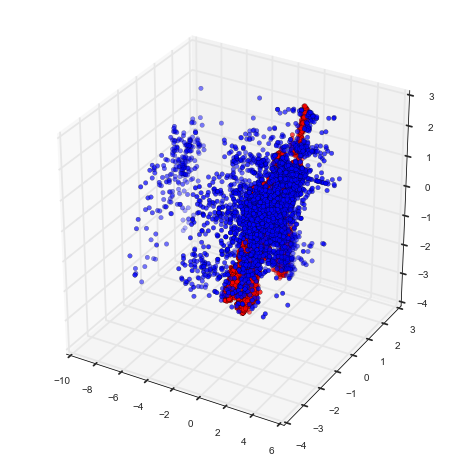

In [351]:
labelmode_cd, count = scipy.stats.mstats.mode(Z_samples_cd[burnin:])
labelmode_cd = np.squeeze(labelmode_cd)
cluster1_cd = calldata_new[np.where(labelmode_cd[:,0]==1)]
cluster2_cd = calldata_new[np.where(labelmode_cd[:,1]==1)]


fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(cluster1_cd[:,0], cluster1_cd[:,1], cluster1_cd[:,2], c = 'red')
ax.scatter(cluster2_cd[:,0], cluster2_cd[:,1], cluster2_cd[:,2], c = 'blue')
plt.show()

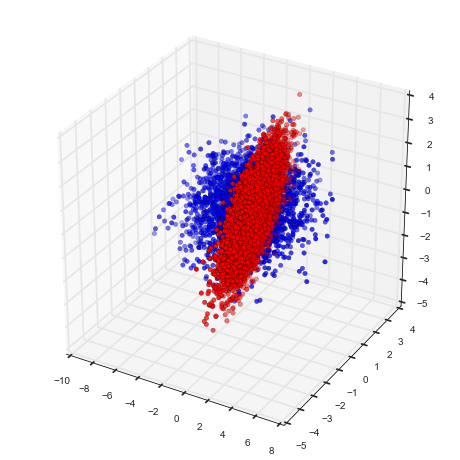

In [354]:
predictedvals_cd, predictedlabels_cd = posterior_predictive(pi_samples_cd[burnin:], 
                                                      mu_samples_cd[burnin:], 
                                                      Sigma_samples_cd[burnin:])


cluster1_cd_predict = predictedvals_cd[np.where(predictedlabels_cd[:,0]==1)]
cluster2_cd_predict = predictedvals_cd[np.where(predictedlabels_cd[:,1]==1)]

fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
ax.scatter(cluster1_cd_predict[:,0], cluster1_cd_predict[:,1], cluster1_cd_predict[:,2], c = 'red')
ax.scatter(cluster2_cd_predict[:,0], cluster2_cd_predict[:,1], cluster2_cd_predict[:,2], c = 'blue')
plt.show()

In [400]:
pi_test = np.array([0.35, 0.45, 0.2])

In [401]:
diff = np.diff(pi_test)
print diff

[ 0.1  -0.25]


In [426]:
print calldata.shape

(10211, 3)
